In [25]:
#import libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [26]:
#config
BASE_PATH = "/kaggle/input/acne-grading-classificationdataset/Created Dataset"
CLASSES = ["Level_0", "Level_1", "Level_2"]
IMG_SIZE = 224
PATCH_SIZE = 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2
PROJECTION_DIM = 768
NUM_HEADS = 12
TRANSFORMER_LAYERS = 12
BATCH_SIZE = 16
SSL_EPOCHS = 50   
FINAL_EPOCHS = 100

In [27]:
#data preparation
filepaths, labels = [], []
for cls in CLASSES:
    folder = os.path.join(BASE_PATH, cls)
    if os.path.exists(folder):
        for f in os.listdir(folder):
            if f.lower().endswith((".jpg", ".png", ".jpeg")):
                filepaths.append(os.path.join(folder, f))
                labels.append(cls)

df = pd.DataFrame({"filename": filepaths, "class": labels})

# %90 SSL, %10 Sınıflandırma
ssl_df, downstream_df = train_test_split(df, test_size=0.10, stratify=df["class"], random_state=42)

# %10'luk kısmın %80 train, %20 test 
train_df, test_df = train_test_split(downstream_df, test_size=0.20, stratify=downstream_df["class"], random_state=42)

def prepare_ssl_dataset(df):
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        return image / 255.0

    def augment(image):
        v1 = tf.image.random_flip_left_right(image)
        v1 = tf.image.random_brightness(v1, 0.2)
        v2 = tf.image.random_contrast(image, 0.8, 1.2)
        v2 = tf.image.random_saturation(v2, 0.8, 1.2)
        return (v1, v2), 0

    ds = tf.data.Dataset.from_tensor_slices(df["filename"].values)
    ds = ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

ssl_ds = prepare_ssl_dataset(ssl_df)

In [28]:
#vit backbone
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches + 1, output_dim=projection_dim)
        self.cls_token = self.add_weight(shape=(1, 1, projection_dim), initializer="zeros", trainable=True)

    def call(self, patches):
        batch_size = tf.shape(patches)[0]
        cls_broadcasted = tf.cast(tf.broadcast_to(self.cls_token, [batch_size, 1, self.projection.units]), patches.dtype)
        encoded = tf.concat([cls_broadcasted, patches], axis=1)
        positions = tf.range(start=0, limit=self.num_patches + 1, delta=1)
        encoded = encoded + self.position_embedding(positions)
        return encoded

def create_vit_backbone():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    patches = layers.Conv2D(PROJECTION_DIM, kernel_size=PATCH_SIZE, strides=PATCH_SIZE)(inputs)
    patches = layers.Reshape((NUM_PATCHES, PROJECTION_DIM))(patches)
    x = PatchEncoder(NUM_PATCHES, PROJECTION_DIM)(patches)

    for _ in range(TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attn = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=PROJECTION_DIM // NUM_HEADS)(x1, x1)
        x2 = layers.Add()([attn, x])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        mlp = layers.Dense(PROJECTION_DIM * 4, activation=tf.nn.gelu)(x3)
        mlp = layers.Dense(PROJECTION_DIM)(mlp)
        x = layers.Add()([mlp, x2])

    representation = layers.Lambda(lambda t: t[:, 0])(x)
    return Model(inputs, representation, name="vit_backbone")

backbone = create_vit_backbone()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'patch_encoder_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [29]:
#ssl
class SimCLR(Model):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = keras.Sequential([layers.Dense(256, activation="relu"), layers.Dense(128)])

    def train_step(self, data):
        (v1, v2), _ = data
        with tf.GradientTape() as tape:
            z1 = self.projection_head(self.backbone(v1))
            z2 = self.projection_head(self.backbone(v2))
            z1, z2 = tf.math.l2_normalize(z1, axis=1), tf.math.l2_normalize(z2, axis=1)
            logits = tf.matmul(z1, z2, transpose_b=True) / 0.1
            labels = tf.range(tf.shape(z1)[0])
            loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels, logits))
        
        self.optimizer.apply_gradients(zip(tape.gradient(loss, self.trainable_variables), self.trainable_variables))
        return {"loss": loss}

simclr_model = SimCLR(backbone)
simclr_model.compile(optimizer=keras.optimizers.Adam(1e-4))

ssl_callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]

print("Ssl pre-train: ")
simclr_model.fit(ssl_ds, epochs=SSL_EPOCHS, callbacks=ssl_callbacks)

Ssl pre-train: 
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - loss: 2.6708
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 2.6075
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 2.5071
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 2.3115
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 2.5840
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 2.5032
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 2.2296
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 2.6958
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 2.6960
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 2.6960
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 2.6956


In [30]:
#fine-tuning

#focal-loss/mixup
def balanced_focal_loss(gamma=2.5):
    alpha_weights = tf.constant([0.86, 0.70, 3.60], dtype=tf.float32) 
    def loss_fn(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=len(CLASSES))
        y_true = tf.cast(y_true, tf.float32)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        focal_term = tf.math.pow(1.0 - y_pred, gamma)
        return tf.math.reduce_sum(alpha_weights * focal_term * cross_entropy, axis=1)
    return loss_fn

backbone.trainable = False
for layer in backbone.layers[-14:]:
    layer.trainable = True

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
features = backbone(inputs)
outputs = layers.Dense(len(CLASSES), activation="softmax")(features)
final_model = Model(inputs, outputs)

final_model.compile(optimizer=keras.optimizers.Adam(1e-5), loss=balanced_focal_loss(), metrics=["accuracy"])

# Veri Yükleyiciler (Mixup'lı eğitim için hazırla)
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_loader = train_gen.flow_from_dataframe(train_df, x_col="filename", y_col="class", target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse")
test_loader = test_gen.flow_from_dataframe(test_df, x_col="filename", y_col="class", target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse", shuffle=False)

final_callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]

print("Fine-Tuning: ")
history = final_model.fit(train_loader, validation_data=test_loader, epochs=FINAL_EPOCHS, callbacks=final_callbacks)

Found 80 validated image filenames belonging to 3 classes.
Found 20 validated image filenames belonging to 3 classes.
2. AŞAMA: Fine-Tuning Başlıyor (Focal Loss & 16-4 Dağılımı)...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.2295 - loss: 5.9751 - val_accuracy: 0.4000 - val_loss: 5.6766
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step - accuracy: 0.2446 - loss: 5.9613 - val_accuracy: 0.1500 - val_loss: 5.5504
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step - accuracy: 0.1439 - loss: 5.3145 - val_accuracy: 0.1500 - val_loss: 5.1828
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - accuracy: 0.2069 - loss: 5.5658 - val_accuracy: 0.4000 - val_loss: 5.2261
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - accuracy: 0.3262 - loss: 5.9034 - val_accuracy: 0.1500 - val_loss: 5.2348
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 364ms/step - accuracy: 0.1248 - loss: 5.9003 - val_accuracy: 0.4000 - val_loss: 5.1854
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 366ms/step - accuracy: 0.3677 - loss: 5.9195 - val_accuracy: 0.4000 - val_loss: 5.2023
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.3102 - loss: 4.6579 - val_accuracy: 0.1500 - val_loss: 5.212

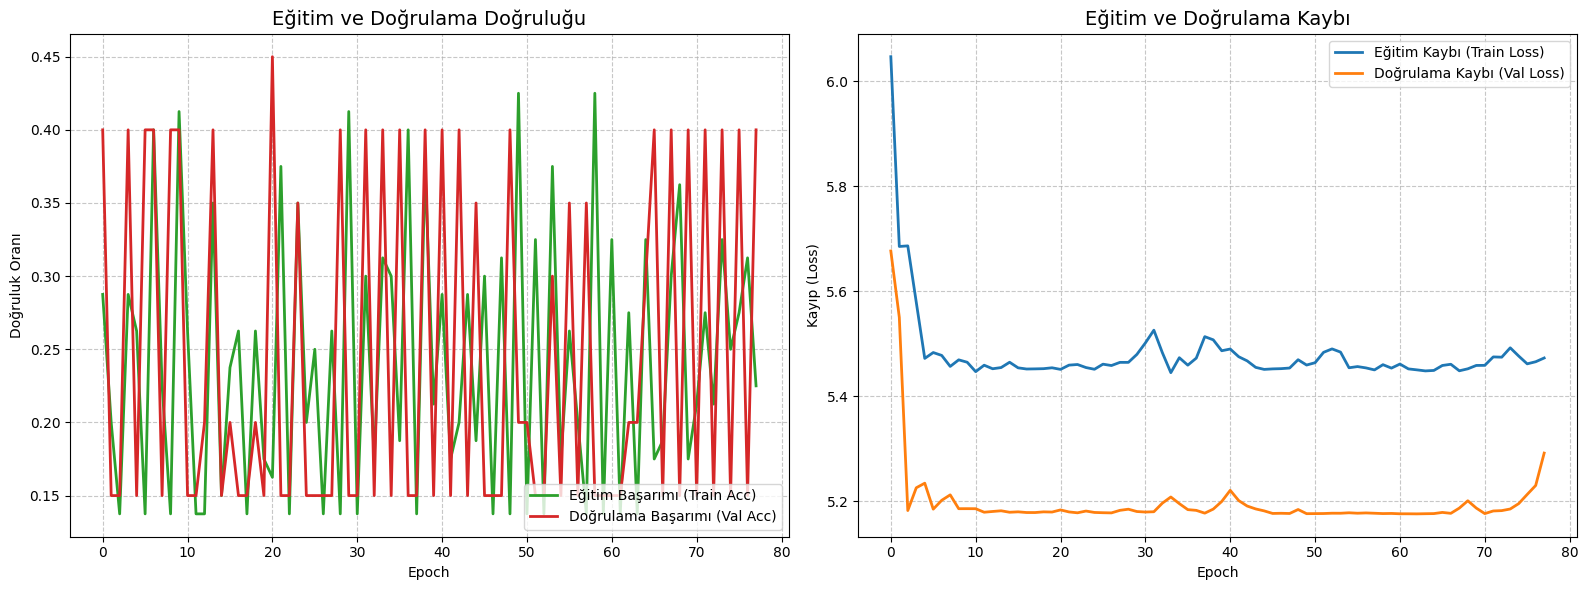

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


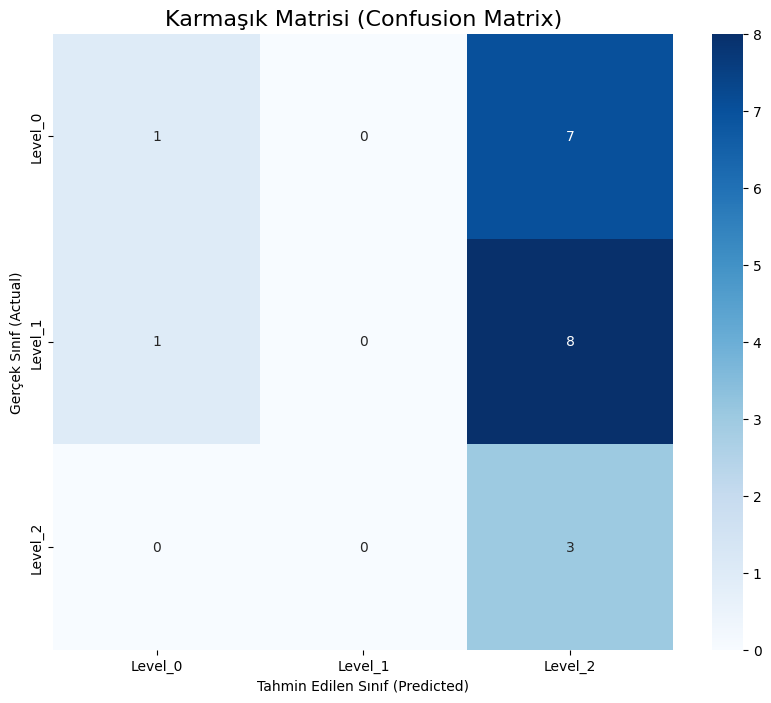


Sınıflandırma Raporu:
              precision    recall  f1-score   support

     Level_0       0.50      0.12      0.20         8
     Level_1       0.00      0.00      0.00         9
     Level_2       0.17      1.00      0.29         3

    accuracy                           0.20        20
   macro avg       0.22      0.38      0.16        20
weighted avg       0.23      0.20      0.12        20



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
def plot_results(history):
    # Accuracy ve Loss Grafiklerini Çizdirme
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 6))
    
    # Doğruluk Grafiği
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Eğitim Başarımı (Train Acc)', color='#2ca02c', lw=2)
    plt.plot(epochs_range, val_acc, label='Doğrulama Başarımı (Val Acc)', color='#d62728', lw=2)
    plt.title('Eğitim ve Doğrulama Doğruluğu', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Doğruluk Oranı')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Kayıp Grafiği
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Eğitim Kaybı (Train Loss)', color='#1f77b4', lw=2)
    plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı (Val Loss)', color='#ff7f0e', lw=2)
    plt.title('Eğitim ve Doğrulama Kaybı', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp (Loss)')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

plot_results(history)

test_loader.reset()
predictions = final_model.predict(test_loader)
y_pred = np.argmax(predictions, axis=1)
y_true = test_loader.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Karmaşık Matrisi (Confusion Matrix)', fontsize=16)
plt.ylabel('Gerçek Sınıf (Actual)')
plt.xlabel('Tahmin Edilen Sınıf (Predicted)')
plt.show()

print("\nSınıflandırma Raporu:")
print(classification_report(y_true, y_pred, target_names=CLASSES))